# Initialisation

## Collab

### Mise à jour des librairies

In [ ]:
!pip install livelossplot

### Connexion au drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Import des librairies

In [2]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import regularizers
from PIL import Image
import seaborn as sns
from keras.utils import to_categorical
import cv2
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from livelossplot import PlotLossesKeras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

import numpy as np
import random
import joblib
from keras.utils import to_categorical
import shutil

import tqdm
import keras
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras import layers
from keras.layers import Input, Lambda, Dense, Flatten

import sys
sys.path.insert(0, r"D:\Documents\Ecole\Rendus_Ecole_Simplon\PCO\reconnaissance_iris\code\fonctions")
from gestion_data.create_train_val_test_data import create_train_val_test_data
from gestion_data.get_data_for_training import get_data_for_training, check_donnees
from data_augmentation.data_augmentation import show_augmentation
from metriques import plot_matrix

# Préparation des jeux de données

### Création train_val_test_data pour import des jeux de données

Création d'un nouveau dossier data avec à la place de chaque dossier contenant des photos, des dossiers appelé train, val et test contenant respectivement 3, 1 et 1 photos, afin que lors de l'entraînement des modèles, les modèles voient tout le temps les mêmes photos.

In [101]:
create_train_val_test_data(r"D:\Documents\Ecole\Rendus_Ecole_Simplon\PCO\reconnaissance_iris\code\data\basic")

100%|██████████| 45/45 [00:08<00:00,  5.22it/s]


## Import des jeux d'entraînement, de validation et de test pour les différents modèles.

In [25]:
X_train, y_train, X_val, y_val, X_test, y_test = get_data_for_training(r"D:\Documents\Ecole\Rendus_Ecole_Simplon\PCO\reconnaissance_iris\code\data\train_val_test_data", "right")

100%|██████████| 45/45 [00:00<00:00, 354.82it/s]


### Check des données

In [263]:
print(len(X_train))
print(len(X_val))
print(len(X_test))

270
90
90


right


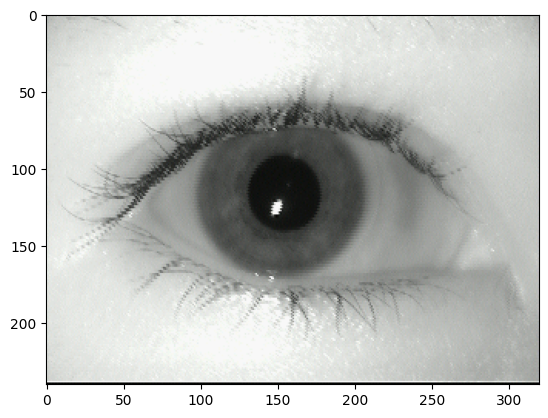

In [264]:
check_donnees(X_train, y_train, 6)

left


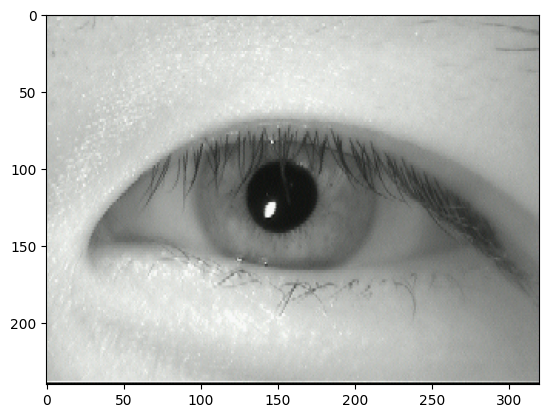

In [265]:
check_donnees(X_val, y_val, 6)

left


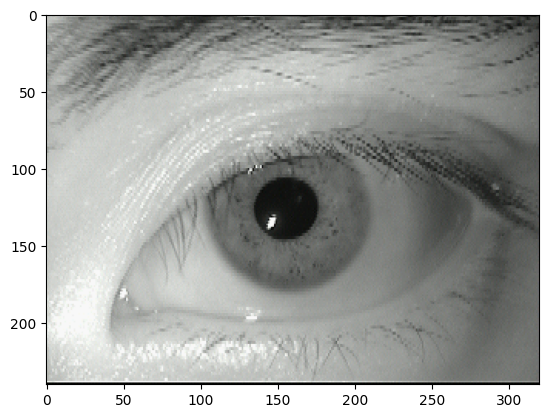

In [266]:
check_donnees(X_test, y_test, 6)

# Data augmentation

In [4]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomZoom((-0.016, 0.016)),
    layers.experimental.preprocessing.RandomRotation((-0.016, 0.016)),
])

left


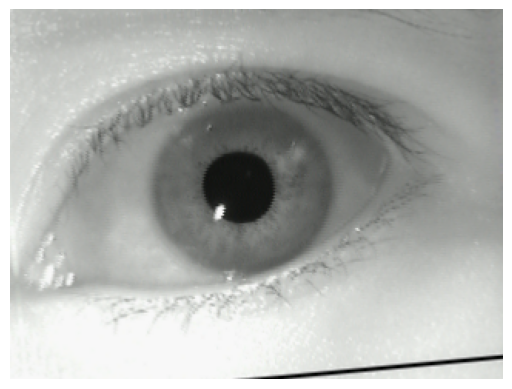

In [5]:
show_augmentation(data_augmentation, X_train, y_train)

# Prétraitement des données

In [26]:
labelenc = LabelEncoder()
y_train_enc = labelenc.fit_transform(y_train)
y_val_enc = labelenc.transform(y_val)
y_test_enc = labelenc.transform(y_test)

In [27]:
y_train_cat, y_val_cat, y_test_cat = to_categorical(y_train_enc), to_categorical(y_val_enc), to_categorical(y_test_enc)

### Check des données n°2

['right']


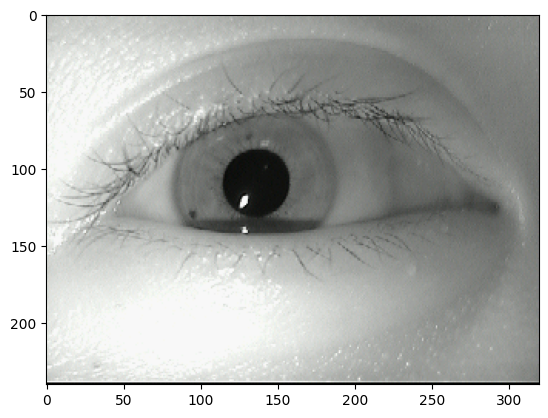

In [272]:
plt.imshow(X_train[0])
y_target = np.argmax(y_train_cat[0], axis=None, out=None)
y_target = labelenc.inverse_transform(np.array([y_target]))
print(y_target)

# Modèles

In [28]:
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=55)
early = EarlyStopping(monitor='val_loss',patience=5, restore_best_weights=True)

### Model 1

In [29]:
def create_model1():

  # Chargement du modèle
  vgg = VGG16(input_shape = (240, 320, 3), weights = 'imagenet', include_top = False)

  # Freeze existing som VGG layers (before two lasts)
  for layer in vgg.layers:
      layer.trainable = False

  input_tensor = Input(shape=(None, None, 3))

  # Réajustement de la dimension de l'image
  x = layers.RandomZoom((-0.016, 0.016))(input_tensor)
  x = layers.RandomRotation((-0.016, 0.016))(x)
  x = layers.Resizing(240, 320, crop_to_aspect_ratio=True)(x)

  # Normalisation des pixels
  x = layers.Rescaling(1./255)(x)
  x = vgg(x)
  x = Flatten()(x)
  x = Dense(300, activation="relu")(x)
  x = Dense(45, activation="softmax")(x)

  model = Model(inputs=input_tensor, outputs=x)

  model.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=['accuracy'])

  # Montrer l'architecture du modèle et le nombre de paramètres entrainables
  model.build(input_shape=(None, None, 3))
  model.summary()

  return model

### Model 2

In [254]:
def create_model2():

  input_tensor = Input(shape=(None, None, 3))

  x = data_augmentation(input_tensor)

  # Réajustement de la dimension de l'image
  x = layers.Resizing(IMSIZE[0], IMSIZE[1], crop_to_aspect_ratio=True)(x)

  # Normalisation des pixels
  x = layers.Rescaling(1./255)(x)

  x = layers.Conv2D(16, 3, padding="same", activation="relu")(x)
  x = layers.MaxPooling2D()(x)
  x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
  x = layers.MaxPooling2D()(x)
  x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
  x = layers.MaxPooling2D()(x)
  x = Flatten()(x)
  x = Dense(300, activation="relu")(x)
  x = Dense(NBCLASSES, activation="softmax")(x)

  model = Model(inputs=input_tensor, outputs=x)

  model.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=['accuracy'])

  # Montrer l'architecture du modèle et le nombre de paramètres entrainables
  model.build(input_shape=(None, None, 3))
  model.summary()

  return model

### Modèle début

In [ ]:
def create_model3():

  # Chargement du modèle
  vgg = VGG16(input_shape = IMSIZE, weights = 'imagenet', include_top = False)

  # Freeze existing som VGG layers (before two lasts)
  for layer in vgg.layers:
      layer.trainable = True



  modele_debut = tf.keras.Sequential([
    # Réajustement de la dimension de l'image
    layers.Resizing(IMSIZE[0], IMSIZE[1], crop_to_aspect_ratio=True),
    # Normalisation des pixels
    layers.Rescaling(1./255, input_shape=IMSIZE),
    # Ajout des couches VGG16
    vgg,
    # Ajout d'une couche de neurones
    # Conv2D(32, (3, 3), activation="relu", padding="same"),
    Flatten(),
    Dense(NBCLASSES, activation="softmax")
    ], name="model3")

  modele_debut.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=['accuracy'])

  # Montrer l'architecture du modèle et le nombre de paramètres entrainables
  modele_debut.build(input_shape=((None,) + IMSIZE))
  modele_debut.summary()

  return modele_debut

# Entraînement

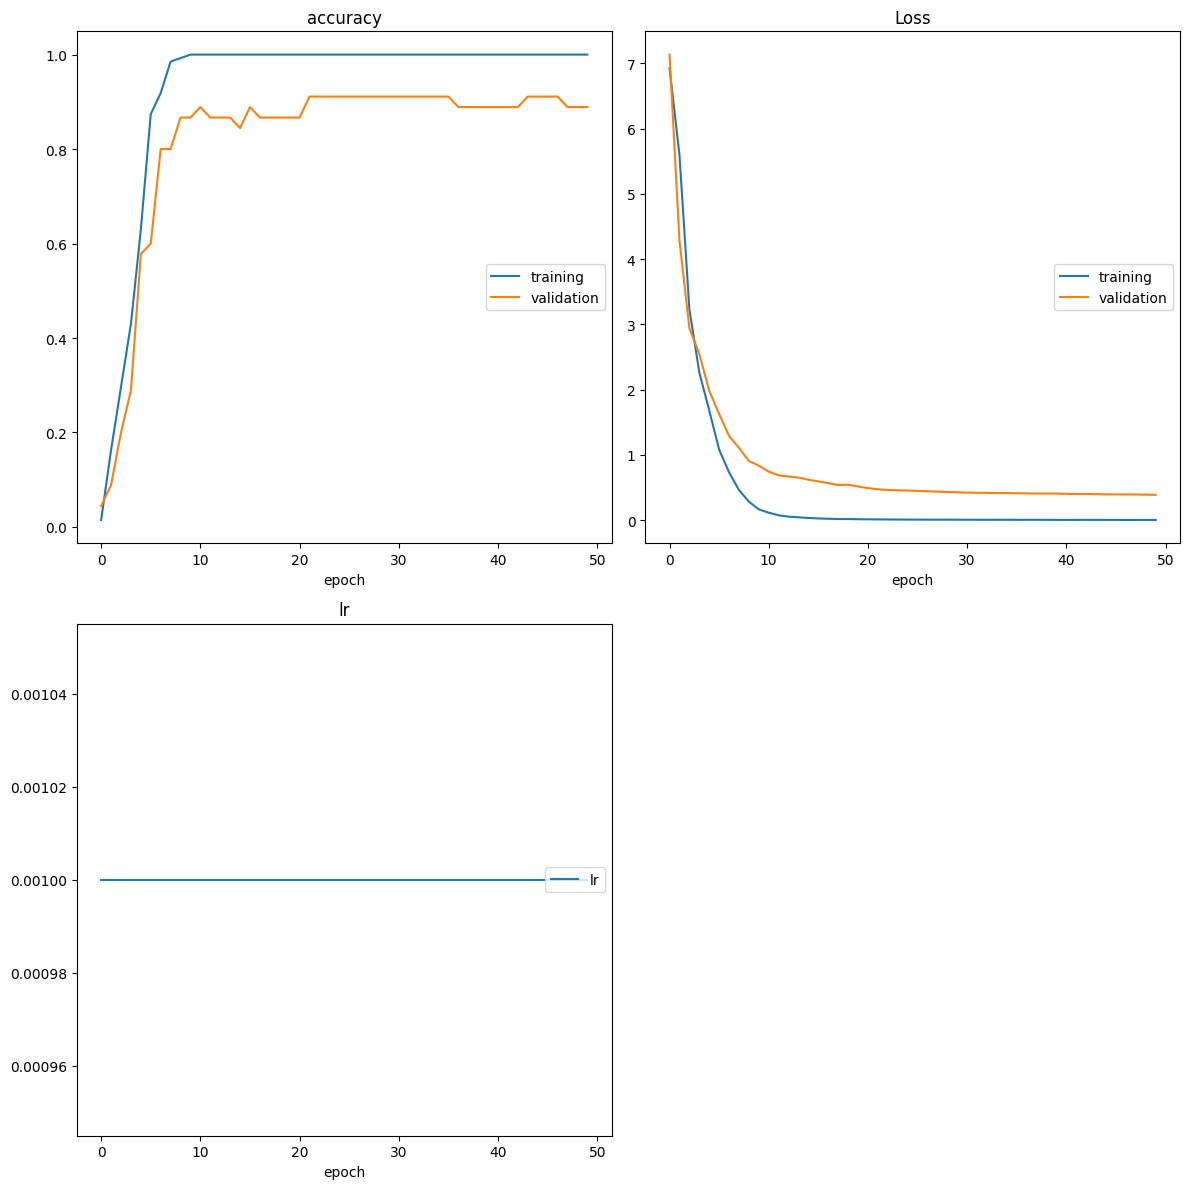

accuracy
	training         	 (min:    0.015, max:    1.000, cur:    1.000)
	validation       	 (min:    0.044, max:    0.911, cur:    0.889)
Loss
	training         	 (min:    0.005, max:    6.925, cur:    0.005)
	validation       	 (min:    0.390, max:    7.133, cur:    0.390)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
3/3 [==============================] - 14s 5s/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.3896 - val_accuracy: 0.8889 - lr: 0.0010


In [30]:
OG_model = create_model1()
OG_model.fit(np.array(X_train), y_train_cat, validation_data=(np.array(X_val), y_val_cat), batch_size = 45, epochs = 50, callbacks = [rlrop, early, PlotLossesKeras()])

# Prédiction

In [31]:
# Exemple de données de test (remplacez cela par vos propres données)
y_pred = [np.argmax(v) for v in OG_model.predict(np.array(X_test))]  # Prédictions du modèle
y_pred = labelenc.inverse_transform(y_pred)

2/2 [==============================] - 3s 943ms/step


In [32]:
# Pour les y correspondant aux numéros employés, cette cellule permet de transformet les etiquettes en integers ('16' en 16)
y_test = [element for element in y_test]
y_pred = [element for element in y_pred]

# Métriques

Matrice de confusion :


d:\Documents\Ecole\Rendus_Ecole_Simplon\PCO\reconnaissance_iris\code\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Précision : 0.90
Rappel : 0.93
Score F1 : 0.91
Exactitude : 0.93
[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]


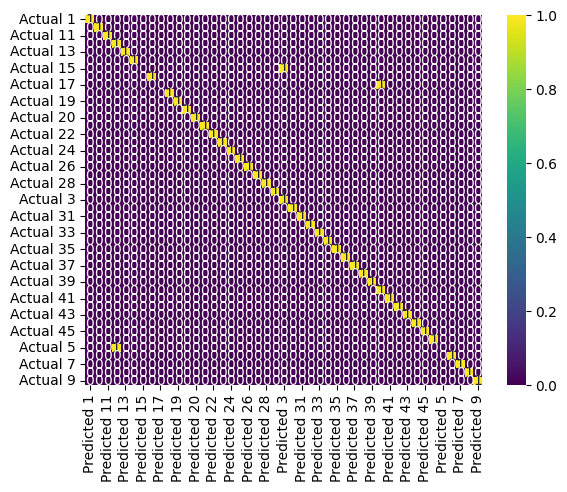

In [33]:
# Calcul de la matrice de confusion prediction = colonne vérité = ligne
conf_matrix = confusion_matrix(np.array(y_test), np.array(y_pred))

# Calcul des mesures de performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("Matrice de confusion :")
plot_matrix(y_test, y_pred)
print("Précision : {:.2f}".format(precision))
print("Rappel : {:.2f}".format(recall))
print("Score F1 : {:.2f}".format(f1))
print("Exactitude : {:.2f}".format(accuracy))
print(conf_matrix)

# Sauvegarde du modèle

In [34]:
OG_model.save(r"D:\Documents\Ecole\Rendus_Ecole_Simplon\PCO\reconnaissance_iris\code\modeles\nouvelle_data_aug\droit\modeledroit.hdf5")
# OG_model.save(r"/content/drive/MyDrive/Detection_yeux/modeles/nouvelle_data_aug/gauche/modele_gauche.hdf5")

d:\Documents\Ecole\Rendus_Ecole_Simplon\PCO\reconnaissance_iris\code\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [35]:
joblib.dump(labelenc, r"D:\Documents\Ecole\Rendus_Ecole_Simplon\PCO\reconnaissance_iris\code\modeles\nouvelle_data_aug\droit\labelenc")
# joblib.dump(labelenc, r"/content/drive/MyDrive/Detection_yeux/modeles/nouvelle_data_aug/gauche/labelenc")

['D:\\Documents\\Ecole\\Rendus_Ecole_Simplon\\PCO\\reconnaissance_iris\\code\\modeles\\nouvelle_data_aug\\droit\\labelenc']